In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
import nest as sim
import numpy as np
import pandas
from collections import Counter
import time as tm
import scipy.stats
from scipy.io import loadmat
import pandas as pd
from datetime import datetime
import os


### Params

In [49]:
y_dim = (0.5* np.sqrt(3))
Nx = 20
Ny = int(np.ceil(Nx * y_dim))
N = Nx * Ny

sigma = 0.1

I_init = 300.0 #pA
I_init_dur = 100.0 #ms
I_init_pos = 0


grid_space = 70 #cm
grid_phase = 0
grids = {}
spacex = grid_space/Nx
spacey = grid_space/Ny

### Network input

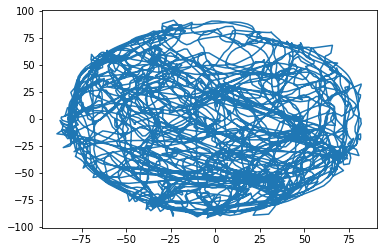

In [50]:
posedata = np.load('data/rat_data_test_run/body_pose.npy')
pos_x = np.array(posedata[:,2]*100)
pos_y = np.array(posedata[:,3]*100)
plt.plot(pos_x,pos_y)

In [52]:
# for every grid cell calculate centers of grid firing fields
for gc in range(N):
    grid_center = [(gc%Nx)*spacex, (gc//Nx)*spacey]
    centers = np.array([grid_center])
    for i in np.arange(env_rad//grid_space+1):
        i+=1
        y = np.around(np.sin(grid_phase)*(i*grid_space),2)
        x = np.around(np.cos(grid_phase)*(i*grid_space),2)
            
        # horizontal
        centers =np.vstack((centers,np.add(grid_center,(x,y))))
        centers =np.vstack((centers,np.add(grid_center,(-x,-y))))
    
    # 60 degrees
    c = np.array([grid_center])
    for horz in centers:
        for i in np.arange(env_rad//grid_space+1):
            i+=1
            y = np.around(np.sin(grid_phase+(np.pi/3))*(i*grid_space),2)
            x = np.around(np.cos(grid_phase+(np.pi/3))*(i*grid_space),2)

            c =np.vstack((c,np.add(horz,(x,y))))
            c =np.vstack((c,np.add(horz,(-x,-y))))
            c =np.vstack((c,np.add(horz,(-x,y))))
            c =np.vstack((c,np.add(horz,(x,-y))))
    centers =np.unique(np.vstack((centers,c)),axis=0)
    grids[gc] = centers

(-100.0, 100.0)

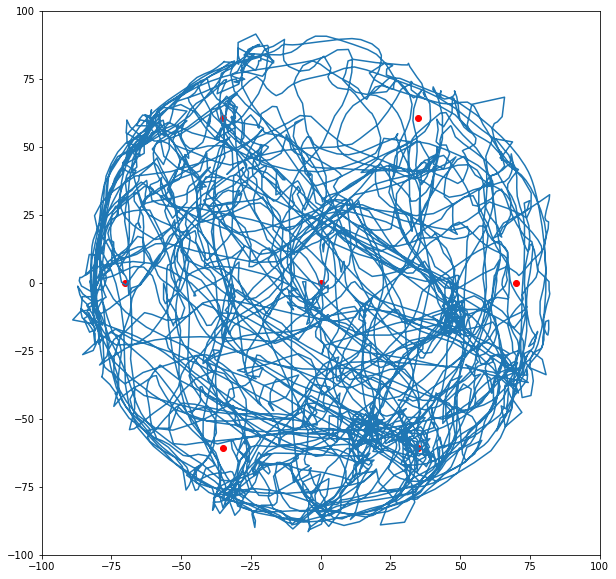

In [53]:
plt.figure(figsize=(10,10))
plt.plot(pos_x,pos_y)
plt.scatter(grids[0][:,0],grids[0][:,1],color = 'r')
plt.xlim([-100,100])
plt.ylim([-100,100])

In [54]:
# for each position find the closest grid center:
closest_gcs = np.zeros(len(pos_x))*np.nan
for i in range(len(pos_x)):
    x = pos_x[i]
    y = pos_y[i]
    min_d = 100000000000
    temp = None
    for gc in range(N):
        centers = grids[gc]
        d = min(np.sqrt((x - centers[:,0])**2 + (y - centers[:,1])**2))
        if d < min_d:
            min_d = d
            temp = gc
    closest_gcs[i] = temp

In [55]:
grid_cell_input = np.empty((len(closest_gcs),N))
for n,gc in enumerate(closest_gcs):
    x_gc = (gc%Nx) / Nx
    y_gc = y_dim*(gc//Nx)/ Ny
    for i in range(N): 
        x_i = (i%Nx) / Nx 
        y_i = y_dim*(i//Nx) / Ny

        d1 = np.sqrt(abs(x_gc - x_i)**2 + abs(y_gc - y_i)**2)
        d2 = np.sqrt(abs(x_gc - x_i - 0.5)**2 + abs(y_gc - y_i + y_dim)**2)
        d3 = np.sqrt(abs(x_gc - x_i - 0.5)**2 + abs(y_gc - y_i - y_dim)**2)
        d4 = np.sqrt(abs(x_gc - x_i + 0.5)**2 + abs(y_gc - y_i + y_dim)**2)
        d5 = np.sqrt(abs(x_gc - x_i + 0.5)**2 + abs(y_gc - y_i - y_dim)**2)
        d6 = np.sqrt(abs(x_gc - x_i - 1.)**2 + abs(y_gc - y_i)**2)
        d7 = np.sqrt(abs(x_gc - x_i + 1.)**2 + abs(y_gc - y_i)**2)
        
        d_ = min(d1,d2,d3,d4,d5,d6,d7)
        grid_cell_input[n,i] = np.exp(-(d_)**2/2/sigma**2)

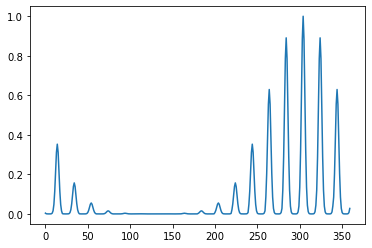

In [56]:
# plt.plot(grid_cell_input[0,:])
# plt.plot(grid_cell_input[10,:])
plt.plot(grid_cell_input[20,:])